In [1]:
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [2]:
path_raw = '/home/matteo@COPPET/Documents/data_science/projects/housing_prices_firenze/data/raw/'

In [3]:
caratteristiche = pd.read_excel(path_raw+'caratteristiche.xlsx')
costi = pd.read_excel(path_raw+'costi.xlsx')
efficienza_energetica = pd.read_excel(path_raw+'efficienza_energetica.xlsx')

In [ ]:
caratteristiche.info()

In [ ]:
costi.info()

In [ ]:
efficienza_energetica.info()

In [4]:
# Drop NaN columns (based on info above, possible error in scraping)
caratteristiche = caratteristiche.drop(columns=['unità', 'Data di inizio lavori e di consegna prevista', 'Dati catastali'])
costi = costi.iloc[:, :3]
efficienza_energetica = efficienza_energetica.iloc[:, :8]

## 1. Data cleaning

### Join all three tables and start looking into the data

In [5]:
# Join tables
df = caratteristiche.join(costi).join(efficienza_energetica)

In [ ]:
df.info()

#### Preliminary cleaning

In [6]:
# Rename columns
df.columns = map(str.capitalize, df.columns)

# Remove rentals
df = df.loc[df['Contratto'] != 'Affitto', :]

# Checking for and removing duplicates
df.duplicated().sum()
df = df.drop_duplicates()

# Not in Firenze
df = df.drop(index=[1279, 4985])

#### Address

In [7]:
df['Indirizzo'] = df['Indirizzo'].str.replace("[",'').str.replace("]",'').str.replace('\'', '')

# Manually impute missing "Zona"
df.loc[df['Indirizzo'] == 'Firenze, via vittorio emanuele orlando', 'Zona'] = 'Coverciano Bellariva'
df.loc[df['Indirizzo'] == 'Firenze, via borgo la noce', 'Zona'] = 'Centro'
df.loc[df['Indirizzo'] == 'Firenze, via Cigoli 31', 'Zona'] = 'L Isolotto'
df.loc[df['Indirizzo'] == 'Firenze, via impruneta per mezzomonte', 'Zona'] = 'Bellosguardo Galluzzo'
df.loc[df['Indirizzo'] == 'Firenze, via gioberti', 'Zona'] = 'Campo Di Marte Liberta'
df.loc[df['Indirizzo'] == 'Firenze, via dei cioli 50', 'Zona'] = 'Settignano Rovezzano'
df.loc[df['Indirizzo'] == 'Firenze, via spinucci 1', 'Zona'] = 'Serpiolle Careggi'
df.loc[df['Indirizzo'] == 'Firenze, "via lungo laffrico 50"', 'Zona'] = 'Coverciano Bellariva'
df.loc[df['Indirizzo'] == 'Firenze, via lippi', 'Zona'] = 'Legnaia Soffiano'
df.loc[df['Indirizzo'] == 'Firenze, cairoli', 'Zona'] = 'Campo Di Marte Liberta'
df.loc[df['Indirizzo'] == 'Firenze, via aretina', 'Zona'] = 'Coverciano Bellariva'
df.loc[df['Indirizzo'] == 'Firenze, via Fra Bartolommeo  40', 'Zona'] = 'Campo Di Marte Liberta'
df.loc[df['Indirizzo'] == 'Firenze, viale don minzoni 1', 'Zona'] = 'Campo Di Marte Liberta'
df.loc[df['Indirizzo'] == 'Firenze, viale don minzoni  1', 'Zona'] = 'Campo Di Marte Liberta'
df.loc[df['Indirizzo'] == 'Firenze, piazza beccaria', 'Zona'] = 'Campo Di Marte Liberta'
df.loc[df['Indirizzo'] == 'Firenze, via san zanobi', 'Zona'] = 'Centro'
df.loc[df['Indirizzo'] == 'Firenze, Piazzale Michelangelo', 'Zona'] = 'Michelangelo Porta Romana'
df.loc[df['Indirizzo'] == 'Firenze, Via del Paradiso', 'Zona'] = 'Zona Firenze Sud'
df.loc[df['Indirizzo'] == 'Firenze, via di Canonica', 'Zona'] = 'Centro'
df.loc[df['Indirizzo'] == 'Firenze, Via di Canonica', 'Zona'] = 'Centro'
df.loc[df['Indirizzo'] == 'Firenze, Via Frusa', 'Zona'] = 'Campo Di Marte Liberta'
df.loc[df['Indirizzo'] == 'Firenze, Via Vespucci', 'Zona'] = 'Firenze Nord'
df.loc[df['Indirizzo'] == 'Firenze, via baracca  148', 'Zona'] = 'Firenze Nord'
df.loc[df['Indirizzo'] == 'Firenze, via dei Tavolini 1', 'Zona'] = 'Centro'
df.loc[df['Indirizzo'] == 'Firenze, via Pisana 980', 'Zona'] = 'Ugnano Mantignano'
df.loc[df['Indirizzo'] == 'Firenze, VIA SENESE', 'Zona'] = 'Bellosguardo Galluzzo'
df.loc[df['Indirizzo'] == 'Firenze, "piazza dAzeglio"', 'Zona'] = 'Centro'
df.loc[df['Indirizzo'] == 'Firenze, "Piazza dazeglio"', 'Zona'] = 'Centro'

#### Zona

In [8]:
df['Zona'] = df['Zona'].fillna('Non specificato')

df['Zona'] = (df['Zona']
              .str.replace('-', ' ')
              .str.replace('/', '')
              .str.title())

#### Price

In [9]:
# Missing labels
df.loc[df['Prezzo'] == 'Prezzo su richiesta', :].shape

(289, 25)

In [10]:
# Drop missing labels
df = df.loc[df['Prezzo'] != 'Prezzo su richiesta', :]

In [11]:
df['Prezzo [EUR]'] = (df['Prezzo']
                      .str.split('€')
                      .str[1]
                      .str.replace('.', '')
                      .astype('float'))

In [12]:
df['Prezzo [EUR]'].isna().sum()

0

#### Area

In [21]:
df['Superficie [m2]'] = df['Superficie'].copy()

In [22]:
def extract_area(row):
    try:
        if '\|' in row['Superficie']:
            row['Superficie [m2]'] = float(re.search('(\d+\.?\d*)',
                                                   row['Superficie'].split('\|')[1]).group(0).replace('.', ''))
        else:
            row['Superficie [m2]'] = float(re.search('(\d+\.?\d*)',
                                                   row['Superficie']).group(0).replace('.', ''))
    except TypeError:
        pass
    return row['Superficie [m2]']

In [23]:
df['Superficie [m2]'] = df.apply(extract_area, axis=1)

In [87]:
# Outlier probably 240
df['Superficie [m2]'].max()

16000.0

In [88]:
df.loc[df['Superficie [m2]'].idxmax(), :]

Immobile garantito                                                                     NaN
Riferimento e data annuncio                                              P291 - 31/08/2020
Contratto                                                                          Vendita
Tipologia                                                                          Cascina
Superficie                                                                       16.000 m²
Locali                                   5+ (30 camere da letto; 20 altri), 3+ bagni, c...
Piano                                                    Piano terra, con accesso disabili
Totale piani edificio                                                                    2
Disponibilità                                                                       Libero
Tipo proprietà                                 Intera proprietà, classe immobile signorile
Altre caratteristiche                    Idromassaggio\n                \n\n           ...

In [86]:
df.loc[df['Superficie [m2]'].idxmax(), 'Superficie [m2]'] = 240

In [ ]:
# Drop entries without area
#df = df.dropna(subset=['Superficie [m2]'])

#### State

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

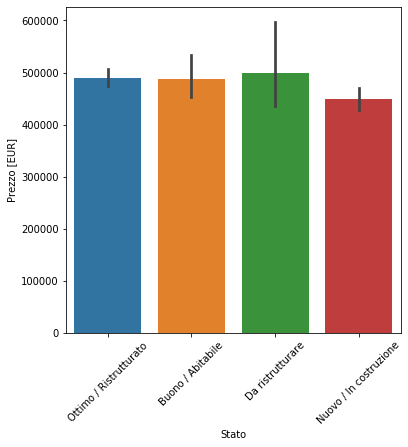

In [26]:
fig = plt.figure(figsize=(6, 6))
sns.barplot(x=df['Stato'], y=df['Prezzo [EUR]'])
plt.xticks(rotation=45)

In [43]:
df['Stato'].value_counts()

Ottimo / Ristrutturato    4769
Buono / Abitabile         2404
Nuovo / In costruzione     897
Da ristrutturare           678
Name: Stato, dtype: int64

In [27]:
# Imputing "Stato" by most frequent as it does not seem to influence price much
df['Stato'] = df['Stato'].fillna(df['Stato'].value_counts().index[0])

#### Contract

In [28]:
# Looking into "Contratto": does it affect price?
gb = df['Prezzo [EUR]'].groupby(df['Contratto']).agg('mean')
gb

Contratto
Vendita                         489644.840990
Vendita | Immobile a reddito    466355.491329
Name: Prezzo [EUR], dtype: float64

#### Dropping useless columns

In [ ]:
# Drop columns that have almost no entries
# Dropping because of lack of entries
# Dropping "Disponibilità" and "Contratto" because it is not relevant information
df = df.drop(columns=['Immobile garantito', 'Indice prest. energetica rinnovabile',
                      'Prestazione energetica del fabbricato', 'Certificazione energetica',
                      'Disponibilità', 'Contratto'])

### Feature engineering

#### Heating

In [29]:
df['Riscaldamento'].isna().sum()

398

In [30]:
# Create type of heating feature
df['Tipologia di riscaldamento'] = df['Riscaldamento'].str.split(',').str[0]

(array([0, 1]), <a list of 2 Text xticklabel objects>)

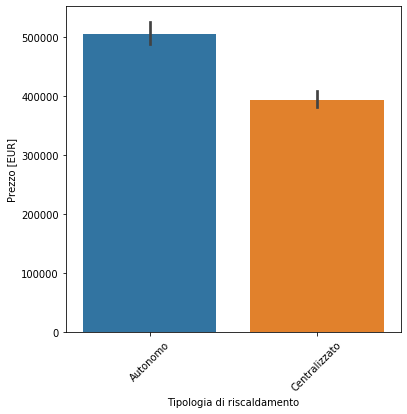

In [31]:
fig = plt.figure(figsize=(6, 6))
sns.barplot(x=df['Tipologia di riscaldamento'], y=df['Prezzo [EUR]'])
plt.xticks(rotation=45)

In [33]:
df['Tipologia di riscaldamento'].value_counts()

Autonomo         6516
Centralizzato    1834
Name: Tipologia di riscaldamento, dtype: int64

In [34]:
# Filling heating NaNs with centralized as if not specified it is probably centralized
df['Tipologia di riscaldamento'] = df['Tipologia di riscaldamento'].fillna('Centralizzato')

#### Listing date

In [35]:
df['Riferimento e data annuncio'].head()

0       A0049 - 05/10/2020
1      alv275 - 05/10/2020
2    Novoli B - 05/10/2020
3    Novoli A - 05/10/2020
4     MAZZ328 - 05/10/2020
Name: Riferimento e data annuncio, dtype: object

In [36]:
df['Data annuncio'] = (df['Riferimento e data annuncio']
                       .str.split('-')
                       .str[-1]
                       .str.strip()
                       .astype('datetime64[D]'))

#### Floor

In [37]:
df['Piano'].unique()

array(['1° piano', '3° piano, con ascensore', '5° piano, con ascensore',
       'da seminterrato a 1°, con ascensore',
       'da seminterrato a piano terra, con ascensore, con accesso disabili',
       '3° piano', '2° piano', 'Piano terra', '1° piano, con ascensore',
       'Piano terra, con ascensore', 'Piano rialzato',
       'da 4° a 5°, con ascensore', '4° piano, con ascensore',
       'Piano rialzato, con ascensore', '6° piano, con ascensore',
       '2° piano, con ascensore, con accesso disabili', 'Seminterrato',
       'da piano terra a piano rialzato', '2° piano, con ascensore',
       'Piano rialzato, con ascensore, con accesso disabili',
       '1° piano, con ascensore, con accesso disabili',
       'Piano terra, con accesso disabili', '4° piano',
       '3° piano, con ascensore, con accesso disabili', nan,
       'da 5° a 6°, con ascensore',
       '5° piano, con ascensore, con accesso disabili',
       '7° piano, con ascensore',
       '4°, con ascensore, con accesso disab

In [38]:
mask = df['Piano'].str.match(r'(.*ascensore.*)')

df['Ascensore'] = mask.astype('float')

In [39]:
df['Totale piani edificio'] = (df['Totale piani edificio']
                               .str.split(' ')
                               .str[0]
                               .astype('float'))

In [40]:
df['Totale piani edificio'].isna().sum()

649

In [41]:
df['Altre caratteristiche'].str.replace('\n', ';')
df['Altre caratteristiche'].unique()[10]

'Giardino privato\n                \n\n                    Esposizione doppia'

#### Number of rooms and toilets

In [44]:
# Create number of rooms feature
pat = r'\(.*\)'
repl = lambda m: m.group(0).replace(',', ';')

df['Locali'] = df['Locali'].str.replace(pat, repl)

In [45]:
# Toilets
df['Numero di bagni'] = (df['Locali']
                         .str.findall(r'(\d\+? bagn\w)')
                         .str[0]
                         .str.split(' ')
                         .str[0])

df.loc[df['Numero di bagni'].isna(), 'Numero di bagni'] = 0
df.loc[df['Numero di bagni'] == '3+', 'Numero di bagni'] = 4 # Set 3+ toilets to 4
df['Numero di bagni'] = df['Numero di bagni'].astype('float')

df['Numero di bagni'].value_counts()

1.0    4428
2.0    2992
3.0     780
4.0     442
0.0     106
Name: Numero di bagni, dtype: int64

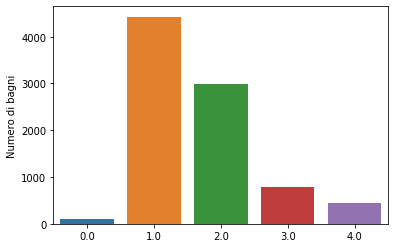

In [46]:
sns.barplot(x=df['Numero di bagni'].value_counts().index, y=df['Numero di bagni'].value_counts())

In [47]:
df.loc[df['Numero di bagni'] == 0, 'Superficie [m2]']

99      120.0
119     500.0
329     250.0
409      95.0
441     200.0
        ...  
8657    350.0
8755     58.0
8773     21.0
8960    172.0
9041    200.0
Name: Superficie [m2], Length: 106, dtype: float64

In [48]:
df['Superficie_Bins'] = pd.cut(df['Superficie [m2]'], bins=[0, 60, 80, 100, 120, 160, 200, 10000])

In [49]:
df['Superficie_Bins'].unique()

[(0.0, 60.0], (60.0, 80.0], (80.0, 100.0], (100.0, 120.0], (120.0, 160.0], (200.0, 10000.0], (160.0, 200.0], NaN]
Categories (7, interval[int64]): [(0, 60] < (60, 80] < (80, 100] < (100, 120] < (120, 160] < (160, 200] < (200, 10000]]

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

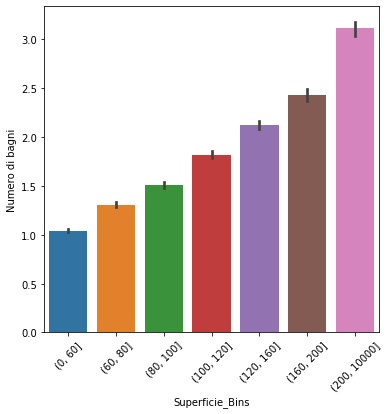

In [50]:
fig = plt.figure(figsize=(6, 6))
sns.barplot(x=df['Superficie_Bins'], y=df['Numero di bagni'])
plt.xticks(rotation=45)

In [51]:
df.groupby(['Superficie_Bins'])['Numero di bagni'].agg(lambda x:x.value_counts().index[0])

Superficie_Bins
(0, 60]         1.0
(60, 80]        1.0
(80, 100]       1.0
(100, 120]      2.0
(120, 160]      2.0
(160, 200]      2.0
(200, 10000]    4.0
Name: Numero di bagni, dtype: float64

In [52]:
# Imputing number of toilets based on area bins
for area in df['Superficie_Bins'].unique():
    mask = df['Superficie_Bins'] == area
    df.loc[mask & (df['Numero di bagni'] == 0), 'Numero di bagni'] = df.loc[mask, 'Numero di bagni'].mode().values

In [53]:
df['Numero di altri'] = (df['Locali']
                         .str.findall(r'(\d?\d\+? altr\w)')
                         .str[0]
                         .str.split(' ')
                         .str[0]
                         .astype('float'))
df.loc[df['Numero di altri'].isna(), 'Numero di altri'] = 0

In [54]:
df['Numero di camere da letto'] = (df['Locali']
                                   .str.findall(r'(\d?\d\+? camer\w da letto)')
                                   .str[0]
                                   .str.split(' ')
                                   .str[0]
                                   .astype('float'))
df.loc[df['Numero di camere da letto'].isna(), 'Numero di camere da letto'] = 0

In [55]:
df['Numero di locali'] = (df['Locali']
                          .str.findall(r'(\d?\d\+? local\w)')
                          .str[0]
                          .str.split(' ')
                          .str[0]
                          .astype('float'))
df.loc[df['Numero di locali'].isna(), 'Numero di locali'] = 0

In [56]:
df['Numero totale di locali'] = df['Numero di locali'] + df['Numero di camere da letto'] + df['Numero di altri']

In [57]:
df['Numero totale di locali'].isna().sum()

0

In [58]:
df.loc[df['Locali'].isna(), :].shape

(13, 36)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

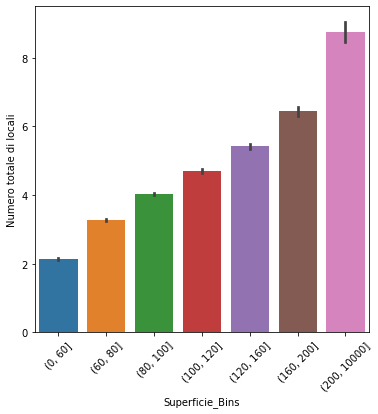

In [59]:
fig = plt.figure(figsize=(6, 6))
sns.barplot(x=df['Superficie_Bins'], y=df['Numero totale di locali'])
plt.xticks(rotation=45)

In [60]:
# Imputing number of rooms based on area bins
for area in df['Superficie_Bins'].unique():
    mask = df['Superficie_Bins'] == area
    df.loc[mask & (df['Numero totale di locali'] == 0),
           'Numero totale di locali'] = df.loc[mask, 'Numero totale di locali'].mode().values

In [61]:
df.loc[mask & (df['Numero totale di locali'] == 0), 'Numero totale di locali']

Series([], Name: Numero totale di locali, dtype: float64)

In [62]:
df.loc[df['Numero totale di locali'].isna(), :].shape

(0, 36)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8748 entries, 0 to 9062
Data columns (total 36 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   Immobile garantito                     3719 non-null   object        
 1   Riferimento e data annuncio            8748 non-null   object        
 2   Contratto                              8748 non-null   object        
 3   Tipologia                              8748 non-null   object        
 4   Superficie                             8742 non-null   object        
 5   Locali                                 8735 non-null   object        
 6   Piano                                  8583 non-null   object        
 7   Totale piani edificio                  8099 non-null   float64       
 8   Disponibilità                          7800 non-null   object        
 9   Tipo proprietà                         8292 non-null   object  

### Selecting final features

In [89]:
df_final = df[['Data annuncio', 'Zona', 'Prezzo [EUR]', 'Tipologia', 'Superficie [m2]',
               'Numero totale di locali', 'Numero di bagni', 'Stato', 'Tipologia di riscaldamento']]

In [90]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8748 entries, 0 to 9062
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Data annuncio               8748 non-null   datetime64[ns]
 1   Zona                        8748 non-null   object        
 2   Prezzo [EUR]                8748 non-null   float64       
 3   Tipologia                   8748 non-null   object        
 4   Superficie [m2]             8742 non-null   float64       
 5   Numero totale di locali     8748 non-null   float64       
 6   Numero di bagni             8748 non-null   float64       
 7   Stato                       8748 non-null   object        
 8   Tipologia di riscaldamento  8748 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 1003.4+ KB


In [91]:
df_final.loc[df_final['Superficie [m2]'].isna(), :]

,Data annuncio,Zona,Prezzo [EUR],Tipologia,Superficie [m2],Numero totale di locali,Numero di bagni,Stato,Tipologia di riscaldamento
5541,2020-09-28,Campo Di Marte Liberta,495000.0,Appartamento,NaN,6.0,3.0,Nuovo / In costruzione,Autonomo
5543,2020-09-28,Campo Di Marte Liberta,695000.0,Appartamento,NaN,6.0,2.0,Nuovo / In costruzione,Autonomo
5544,2020-09-28,Campo Di Marte Liberta,565000.0,Appartamento,NaN,4.0,3.0,Nuovo / In costruzione,Centralizzato
5850,2020-04-21,Zona Bolognese Le Cure,1560000.0,Appartamento,NaN,5.0,2.0,Ottimo / Ristrutturato,Autonomo
5879,2020-07-29,Zona Bolognese Le Cure,1700000.0,Villa unifamiliare,NaN,8.0,4.0,Ottimo / Ristrutturato,Autonomo
5897,2020-04-21,Bellosguardo Galluzzo,3300000.0,Villa unifamiliare,NaN,5.0,4.0,Ottimo / Ristrutturato,Autonomo


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

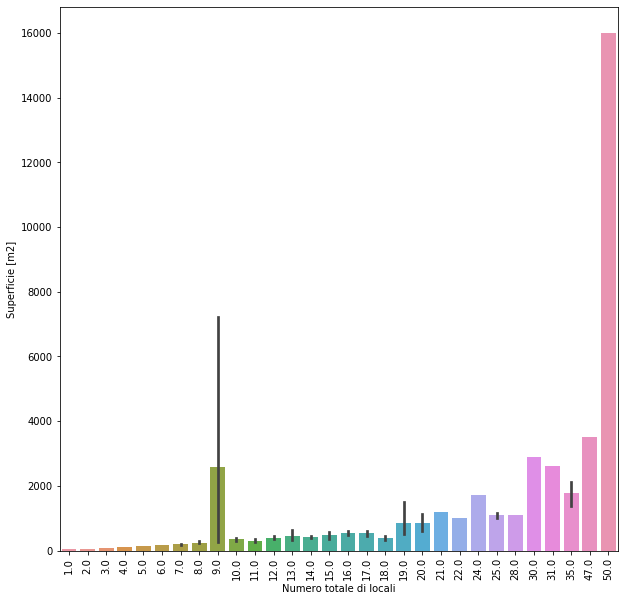

In [67]:
fig = plt.figure(figsize=(10, 10))
sns.barplot(x=df_final['Numero totale di locali'], y=df_final['Superficie [m2]'])
plt.xticks(rotation=90)

(array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.]),
 <a list of 11 Text xticklabel objects>)

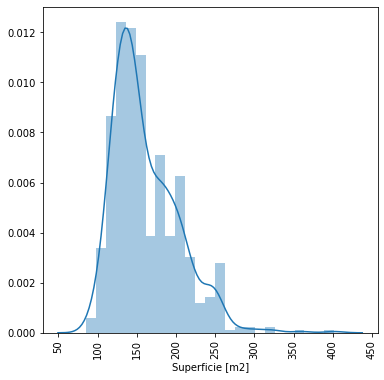

In [92]:
fig = plt.figure(figsize=(6, 6))
sns.distplot(df_final.loc[df_final['Numero totale di locali'] == 6, 'Superficie [m2]'])
plt.xticks(rotation=90)

In [93]:
# Imputing area based on total number of rooms
for rooms in df_final['Numero totale di locali'].unique():
    mask = df_final['Numero totale di locali'] == rooms
    df_final.loc[mask & (df_final['Superficie [m2]'].isna()),
                 'Superficie [m2]'] = df_final.loc[mask, 'Superficie [m2]'].mean()

/home/matteo@COPPET/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [94]:
df_final['Numero totale di locali'].unique()

array([ 2.,  3.,  4.,  5.,  8., 10.,  6.,  9.,  1.,  7., 13., 11., 17.,
       12., 18., 14., 28., 20., 16., 19., 30., 35., 15., 47., 31., 25.,
       21., 24., 22., 50.])

In [95]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8748 entries, 0 to 9062
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Data annuncio               8748 non-null   datetime64[ns]
 1   Zona                        8748 non-null   object        
 2   Prezzo [EUR]                8748 non-null   float64       
 3   Tipologia                   8748 non-null   object        
 4   Superficie [m2]             8748 non-null   float64       
 5   Numero totale di locali     8748 non-null   float64       
 6   Numero di bagni             8748 non-null   float64       
 7   Stato                       8748 non-null   object        
 8   Tipologia di riscaldamento  8748 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 1003.4+ KB


## 2. Exploratory Data Analysis

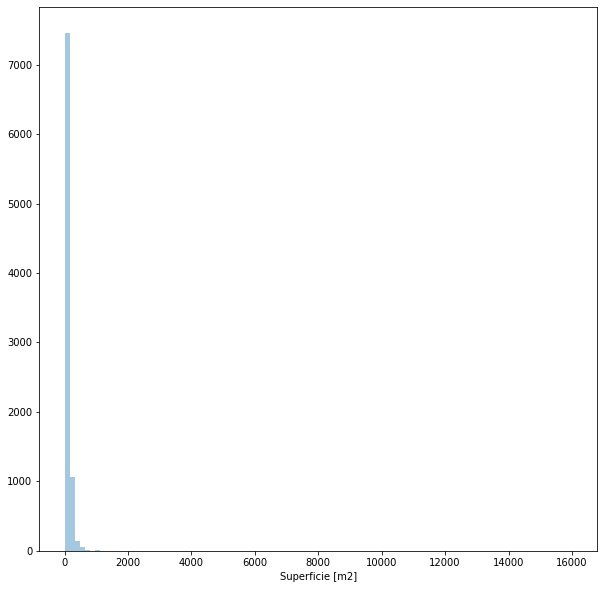

In [97]:
# Area [m2] distribution
fig = plt.figure(figsize=(10, 10))
sns.distplot(df_final['Superficie [m2]'], kde=False, bins=100)

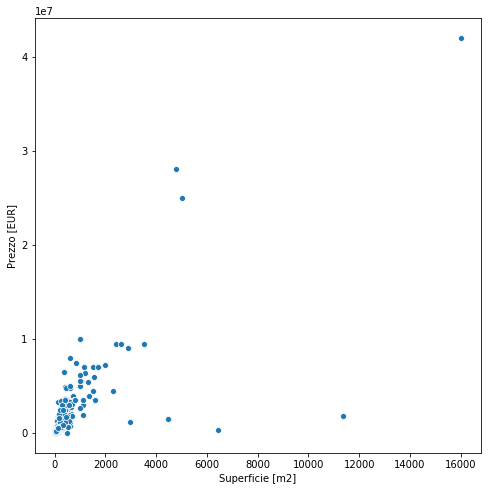

In [98]:
fig = plt.figure(figsize=(8, 8))
sns.scatterplot(x='Superficie [m2]', y='Prezzo [EUR]', data=df_final)

In [ ]:
df_final.loc[df_final['Prezzo [EUR]'].idxmax(), :]